## Imports 

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 


if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()

In [18]:
os.chdir(root)
from data_treatment.box_creator import create_binary_box

df = pd.read_csv('database.csv')
df = create_binary_box(df, threshold=2., box_length=7).set_index("Date").dropna(axis = 0)

## Our model 

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

prescale_X = df.drop(columns="Box")
y = df["Box"]
x = (prescale_X - prescale_X.mean())/prescale_X.std()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
ridge = LogisticRegression(penalty="l2", solver="newton-cg", C = 0.3)
ridge.fit(X_train, y_train)

score= ridge.score(X_train, y_train)
score

0.7772609819121447

### Confusion Matrix

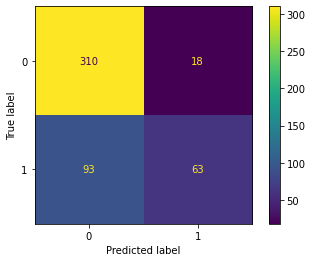

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(ridge, X_test, y_test)


## Getting our precision, recall and f-1 scores

In [26]:
y_pred= ridge.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       328
           1       0.78      0.40      0.53       156

    accuracy                           0.77       484
   macro avg       0.77      0.67      0.69       484
weighted avg       0.77      0.77      0.75       484



### The ROC Curve (receiver operating characteristic)\
plots the true positive rate against the false positive rate \
ie plots sensitivity versus 1- specificity 

In [27]:
y_scores= ridge.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

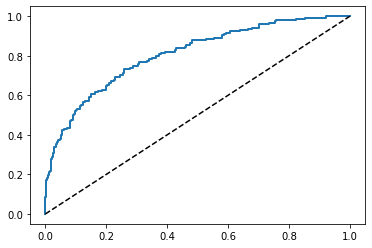

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label= label)
    plt.plot([0,1], [0,1], 'k--') 
    return 

plot_roc_curve(fpr, tpr)
plt.show()

### Area under the curve 

In [29]:
roc_auc_score(y_test, y_scores)

0.8068714821763601